# Audio

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Task 1

Для начала познакомимся с этими записями. \
Установи библиотеку [librosa](https://librosa.org/). Это популярная библиотека для работы с аудио.
Визуализируй аудио сигнал файла `0_1_0_1_1_1_0_0.wav` с помощью функции [librosa.display.waveshow](https://librosa.org/doc/main/generated/librosa.display.waveshow.html)
График должен быть такой же, как показано ниже (по значениям):

![waveform](../misc/images/waveform.png)
>Для того, чтобы прослушать это аудио файл, можешь воспользоваться [IPython.display.Audio](http://ipython.org/ipython-doc/stable/api/generated/IPython.display.html#IPython.display.Audio)

In [ ]:
# ! pip install librosa

In [24]:
import librosa
import os
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import librosa.display as ld
import pandas as pd
import IPython

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, mean_squared_error
from glob import glob
from sklearn import svm
from sklearn import metrics


import sys
sys.path.append('../code-samples')
#sys.path.append('/content/drive/My Drive/School21/project9/DS09-1-master/code-samples')
from audio_utils import load_dataset, make_dataset

In [25]:
#dir ='/content/drive/My Drive/School21/project9/DS09-1-master/datasets/waves_yesno 2'
dir ='../datasets/waves_yesno 2'
file = dir+'/0_1_0_1_1_1_0_0.wav'
signal, sr = librosa.load(file, sr = 22050)

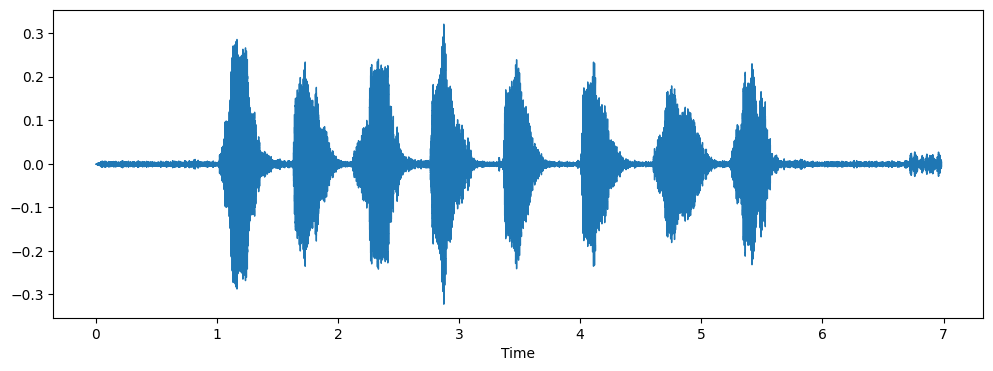

In [26]:
plt.figure(figsize = (12, 4))
ld.waveshow(signal, sr = sr)

display(IPython.display.Audio(signal, rate = sr))

## Task 2

Для классификации обычно использует не просто аудио сигнал, а его частотно-временное представление. Для этого сигнал требуется
преобразовать с помощью [оконного преобразования Фурье](https://clck.ru/34JnZD).
С помощью функции [librosa.display.specshow](https://librosa.org/doc/main/generated/librosa.display.specshow.html)
выведи спектрограмму сигнала. \
График должен быть такой же, как показано ниже (по значениям):
![sftp](../misc/images/sftp.png)

(0.0, 4000.0)

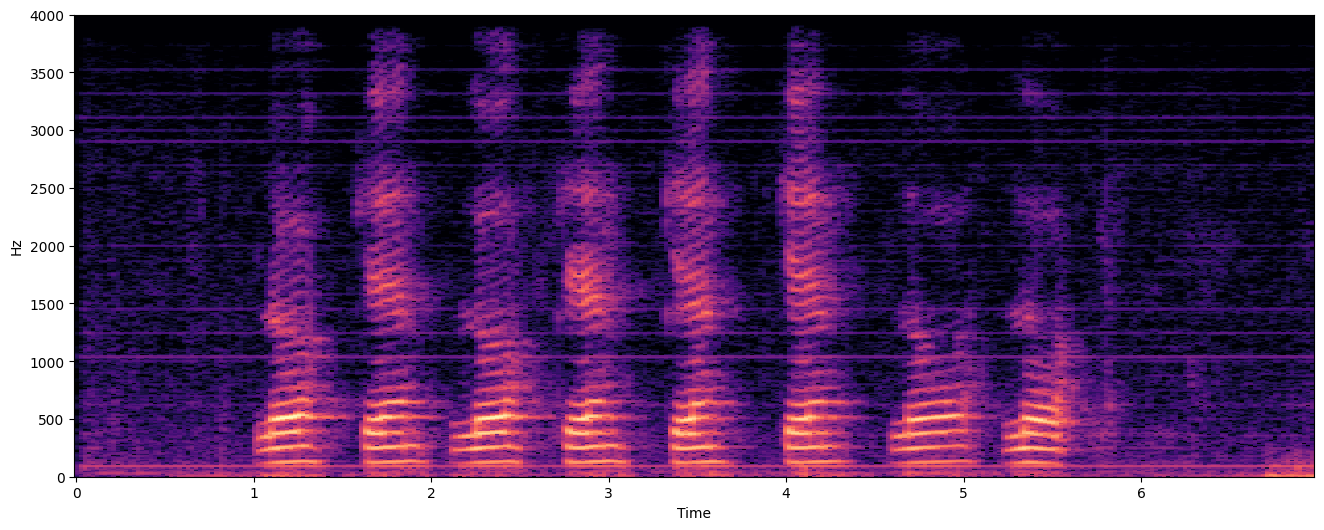

In [27]:
x = librosa.stft(signal)
s = librosa.amplitude_to_db(abs(x))
fig, ax = plt.subplots(figsize = (16, 6))
ld.specshow(s, sr=sr, x_axis ='time', y_axis = 'linear')
ax.set_ylim([0, 4000])
#fig.show()

## Task 3

C помощью функции [load_dataset](code-samples/audio_utils.py) загрузи датасет. \
Раздели его на train и test c параметрами `test_size=0.2`, `random_state=42`. \
Выведи количество файлов в train и test частях.

In [8]:
df_load = load_dataset(dir)
X = df_load[0]
labels = df_load[1]
files = df_load[3]
x_train, x_test, y_train, y_test, file_train, file_test = train_test_split(X, labels, files, test_size=0.2, random_state=42)
print ('x_train', len(x_train), '\nx_test', len(x_test), '\ny_train', len(y_train), '\ny_test', len(y_test))

x_train 47 
x_test 12 
y_train 47 
y_test 12


## Task 4

Наши аудио записи содержат как речь человека, так и молчание. Для каждой записи нам нужно определить сегменты записи,
где человек молчит, а где произносит слова. \
Эта задача называется [Voice Activity Detection (VAD)](https://ru.wikipedia.org/wiki/Voice_Activity_Detection).
Придумайте или найдите метод, по которому можно распознавать участки с речью на аудио записи.

Например:
Запись '0_0_0_1_0_1_1_0.wav' содержит 137592 отсчетов. Сегменты с речью для этой записи (Отмечены красным):
[[23996, 32539],
 [35410, 44925],
 [49493, 57410],
 [60458, 68635],
 [73308, 81278],
 [84001, 91942],
 [97381, 104166],
 [109018, 115573]]
![sftp](../misc/images/vad.png)



Выведи несколько примеров работы твоего VAD-алгоритма, по аналогии с примером, для других аудио записей. Попробуй добиться
наилучшего качества нахождения речи.

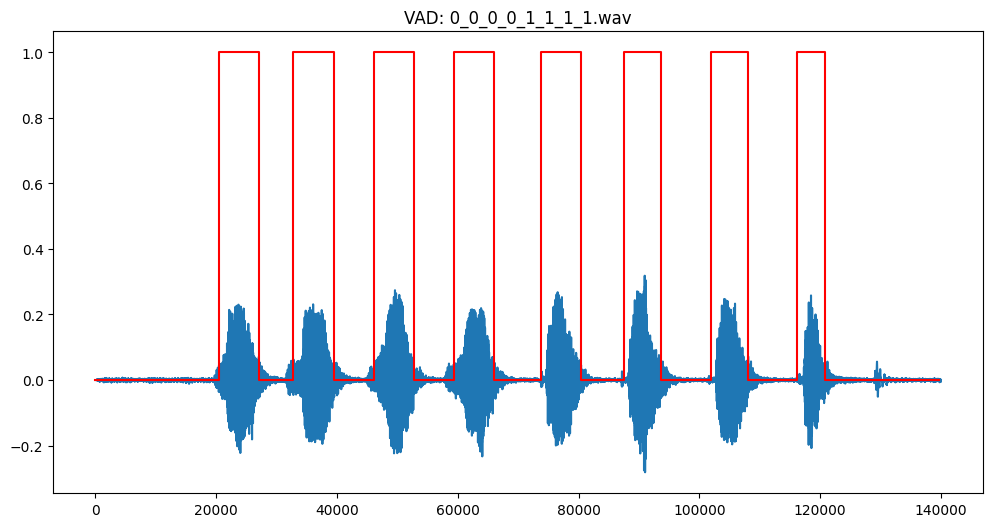

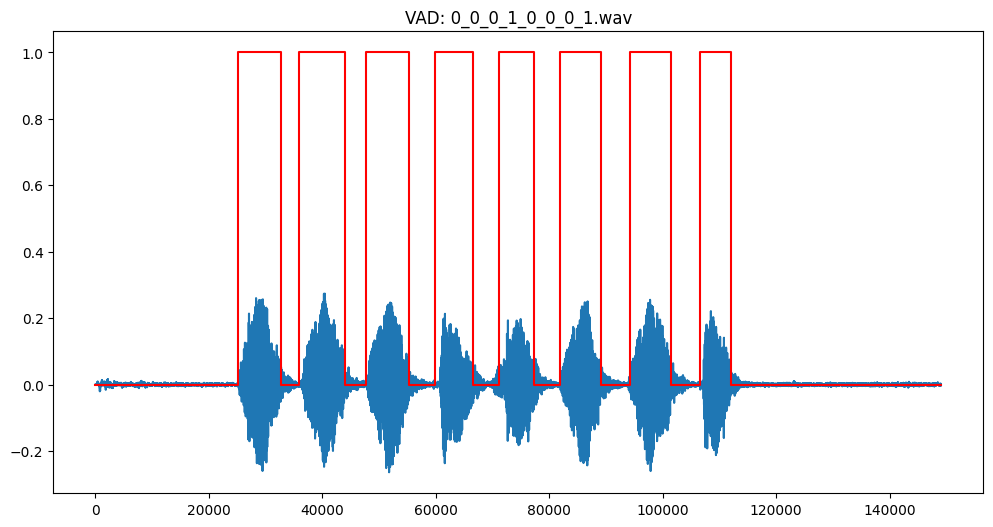

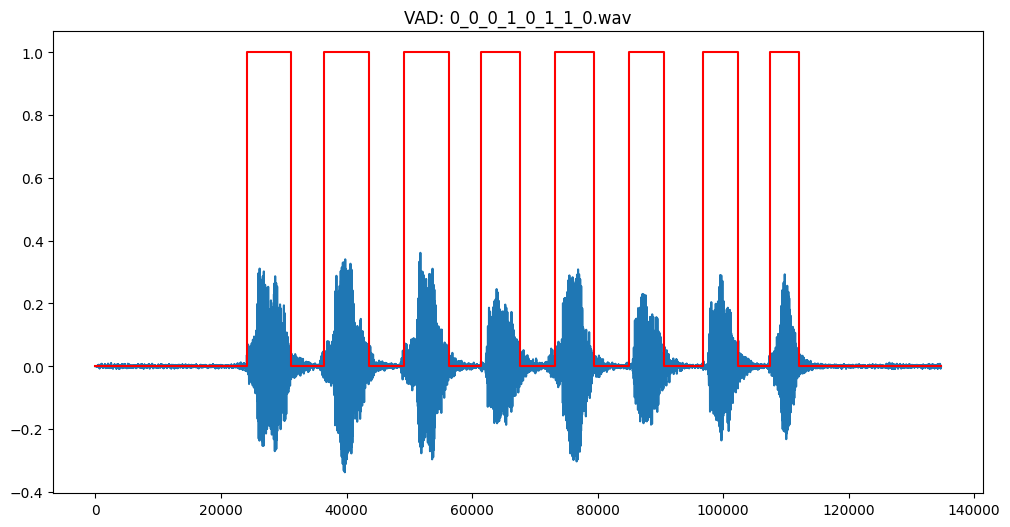

In [22]:
treshold = 0.025
segments_files = []

for i in range(3):
    audio_file =  os.path.join(dir,files[i])
    signal, sr = librosa.load(audio_file)

    S_full, phase = librosa.magphase(librosa.stft(signal))
    rms = librosa.feature.rms(y=signal)[0]
    times = librosa.frames_to_samples(np.arange(len(rms)))
    r_normalized = (rms - treshold) / np.std(rms)
    p = np.exp(r_normalized) / (1 + np.exp(r_normalized))
    plt.figure(figsize=(12, 6))
    plt.plot(signal)
    plt.step(times, p>=0.5, color='r')
    plt.title('VAD: ' + files[i])


In [10]:
treshold = 0.025
segments_files = []

for fw in range(len(files)):
    audio_file =  os.path.join(dir, files[fw])
    signal, sr = librosa.load(audio_file)

    S_full, phase = librosa.magphase(librosa.stft(signal))
    rms = librosa.feature.rms(y=signal)[0]
    times = librosa.frames_to_samples(np.arange(len(rms)))
    r_normalized = (rms - treshold) / np.std(rms)
    p = np.exp(r_normalized) / (1 + np.exp(r_normalized))


    segments = []
    start = None
    for i in range(len(times)):
        if p[i] >= 0.5 and start is None:
            start = times[i]
        elif p[i] < 0.5 and start is not None:
            segments.append([start,times[i]])
            start = None
    segments_files.append(segments)
#print (segments_files)

## Task 5

После того как мы узнали сегменты аудио с речью, то можно перейти к самой задаче классификации. \
Внимательно изучи функцию [make_dataset](code-samples/audio_utils.py). С помощью этой функции cгенерируй X, Y для train и test выборок.
Затем попробуй обучить различные классификаторы. Например, SVM или LogisticRegression.
Измерь точность (accuracy) классификации на тестовой выборке.

In [ ]:
def make_dataset(samples, labels, vad_segments):
    """

    :param samples: Список аудио сигналов
    :param labels: Список меток (Например для файла '0_0_0_1_0_1_1_0.wav': [0, 0, 0, 1, 0, 1, 1, 0])
    :param vad_segments: Список сегментов для каждого аудио сигнала вида:
        [
            [[23996, 32539], [35410, 44925], ...,],
            [[22141, 30259], [34917, 42695], ...,],
            ...
        ]
    :return:
    """
    X, y = [], []
    # Проходим по каждому аудио сигналу
    for sample in range(len(samples)):
        # В аудио сигнале проходим по каждому сегменту с речью
        for segment in range(len(vad_segments[sample]) - 1):
            start = vad_segments[sample][segment][0]  # Начало сегмента
            stop = vad_segments[sample][segment][1]  # Конец сегмента
            voice = samples[sample][start:stop]  # Отрезаем сегмент с речью из аудио сигнала и применяем stft
            stft = librosa.stft(voice).mean(axis=1)
            stft_db = librosa.amplitude_to_db(abs(stft))

            X.append(stft_db)  # Добавляем спектрограмму с речью
            y.append(labels[sample][segment])  # Добавляем метку для этой спектрограммы

    return np.array(X), np.array(y)

In [11]:
x_train, x_test, y_train, y_test, files_train, files_test,segments_files_train, segments_files_test = train_test_split(X, labels, files, segments_files, test_size=0.2, random_state=42)

Xx_train, Yy_train = make_dataset(x_train, y_train, segments_files_train)
Xx_test, Yy_test = make_dataset(x_test, y_test, segments_files_test)

clf = svm.SVC(kernel='rbf')
clf.fit(Xx_train, Yy_train)
y_pred = clf.predict(Xx_test)


print("Accuracy на обучающей выборке: ", metrics.accuracy_score(Yy_train, clf.predict(Xx_train)))
print("Accuracy на тестовой выборке: ",metrics.accuracy_score(Yy_test, y_pred) )

Accuracy на обучающей выборке:  1.0
Accuracy на тестовой выборке:  1.0
